In [90]:
import skimage.io as io
import pandas as pd
import os
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
import ast
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import radius_graph
import progressbar
import tqdm


In [11]:
tiles_path = '/Users/akre96/Data/BE_223B/tiles_rois/normalized/'
centroids_path = '/Users/akre96/Data/BE_223B/tiles_rois/centroids/'
features_path = '/Users/akre96/Data/BE_223B/tiles_rois/nucleus_features/'
labels_path = '/Users/akre96/Data/BE_223B/tiles_rois/dataset.csv'
labels = pd.read_csv(labels_path)

In [12]:
tile_files = os.listdir(tiles_path)
tile_files = [tf for tf in tile_files if tf[0] != '.']


In [13]:
tile_id  = '7664_26880_36736'
#tile_id = tf.split('/')[-1].split('.')[0]
tile = io.imread(os.path.join(tiles_path, tile_id + '.png'))
centroid = pd.read_csv(os.path.join(centroids_path, tile_id + '.csv'))
features = pd.read_csv(os.path.join(features_path, tile_id + '.csv'), converters={"diagnostics_Mask-original_CenterOfMass": ast.literal_eval})
feature_cols = ['original_gldm_DependenceNonUniformity']
label = labels[labels.tile_name == tile_id].label.values

In [19]:
features.head()

,mask_num,diagnostics_Mask-original_CenterOfMass,diagnostics_Image-original_Size,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_Size,diagnostics_Mask-original_BoundingBox,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,0,"(191.85454545454544, 148.03636363636363)","(512, 512)",195.469063,11.0,255.0,94ba3b81cf49defcfe7f41bd952db5d4b0c59241,"(1.0, 1.0)","(512, 512)","(188, 145, 9, 7)",...,3.014925,0.161168,3.132944,0.472727,2.102071,1.455224,0.141026,1.008090,0.044502,0.397980
1,1,"(397.5833333333333, 352.2083333333333)","(512, 512)",195.469063,11.0,255.0,6c50faf45a2015c37c942b1e77e40f6a25e2ca1b,"(1.0, 1.0)","(512, 512)","(394, 349, 8, 7)",...,2.160278,0.262438,2.999080,0.520833,0.953600,2.985294,0.118227,1.311343,0.067835,0.312500
2,2,"(401.24, 121.81333333333333)","(512, 512)",195.469063,11.0,255.0,0e9db87e5b3235aab090ac705bf98d1711c05163,"(1.0, 1.0)","(512, 512)","(397, 117, 9, 11)",...,1.611481,0.381166,2.829237,0.520000,1.353057,2.747340,0.072604,1.441677,0.037337,0.177231
3,3,"(39.35897435897436, 217.10256410256412)","(512, 512)",195.469063,11.0,255.0,1077fb322e391bdc0eb95c5e33e57832cec22ba6,"(1.0, 1.0)","(512, 512)","(36, 214, 7, 7)",...,1.986479,0.219641,3.323231,0.384615,3.706667,0.837054,0.208000,0.780435,0.020651,0.512821
4,4,"(210.55555555555554, 505.5777777777778)","(512, 512)",195.469063,11.0,255.0,37587b673a5e9124af17cf968afee1fea9a29c19,"(1.0, 1.0)","(512, 512)","(207, 502, 8, 8)",...,1.128161,0.411693,2.717972,0.466667,2.027211,11.833333,0.126761,0.350617,0.085048,0.129032


In [15]:
print(features.columns.values)

['mask_num' 'diagnostics_Mask-original_CenterOfMass'
 'diagnostics_Image-original_Size' 'diagnostics_Image-original_Mean'
 'diagnostics_Image-original_Minimum' 'diagnostics_Image-original_Maximum'
 'diagnostics_Mask-original_Hash' 'diagnostics_Mask-original_Spacing'
 'diagnostics_Mask-original_Size' 'diagnostics_Mask-original_BoundingBox'
 'diagnostics_Mask-original_VoxelNum'
 'diagnostics_Mask-original_VolumeNum'
 'diagnostics_Mask-original_CenterOfMassIndex'
 'original_shape2D_Elongation' 'original_shape2D_MajorAxisLength'
 'original_shape2D_MaximumDiameter' 'original_shape2D_MeshSurface'
 'original_shape2D_MinorAxisLength' 'original_shape2D_Perimeter'
 'original_shape2D_PerimeterSurfaceRatio' 'original_shape2D_PixelSurface'
 'original_shape2D_Sphericity' 'original_firstorder_10Percentile'
 'original_firstorder_90Percentile' 'original_firstorder_Energy'
 'original_firstorder_Entropy' 'original_firstorder_InterquartileRange'
 'original_firstorder_Kurtosis' 'original_firstorder_Maximum

In [14]:
coordinates = torch.tensor(features['diagnostics_Mask-original_CenterOfMass'].tolist())
node_features = torch.tensor(features[feature_cols].values, dtype=torch.float32)
y = torch.tensor([label], dtype=torch.long)
data = Data(x = node_features, pos = coordinates, y = y, num_classes=2)
max_neighbours = 8
radius = 50
data.edge_index = radius_graph(data.pos, radius, None, True, max_neighbours)

In [131]:
data_sets = []
failed = []
for tf in progressbar.progressbar(tile_files[:]):
    tile_id = tf.split('/')[-1].split('.')[0]
    tile = io.imread(os.path.join(tiles_path, tile_id + '.png'))
    centroid = pd.read_csv(os.path.join(centroids_path, tile_id + '.csv'))
    if os.path.isfile(os.path.join(features_path, tile_id + '.csv')):
        features = pd.read_csv(os.path.join(features_path, tile_id + '.csv'), converters={"diagnostics_Mask-original_CenterOfMass": ast.literal_eval})
    else:
        failed.append(tile_id)
        continue
    feature_cols = [
        'original_gldm_DependenceNonUniformity',
        'original_glrlm_RunLengthNonUniformity',
        'diagnostics_Mask-original_VoxelNum'
    ]
    feature_cols = [
        f for f in features.columns.values
        if (f not in ['mask_num'])
            and ('diagnostics_Mask-original' not in f)
            and ('diagnostics_Image-original' not in f)
    ]
    label = labels[labels.tile_name == tile_id].label.values
    coordinates = torch.tensor(features['diagnostics_Mask-original_CenterOfMass'].tolist())
    node_features = torch.tensor(features[feature_cols].astype(float).values, dtype=torch.float32)
    y = torch.tensor([[label[0], ~label[0]]], dtype=torch.float) # one hot encoded
    data = Data(x = node_features, pos = coordinates, y = y, num_classes=2)
    max_neighbours = 8
    radius = 50
    data.edge_index = radius_graph(data.pos, radius, None, True, max_neighbours)
    data_sets.append(data)


100% (1000 of 1000) |####################| Elapsed Time: 0:01:05 Time:  0:01:05


In [132]:
len(feature_cols)

102

In [133]:
loader = DataLoader(data_sets, batch_size=8)

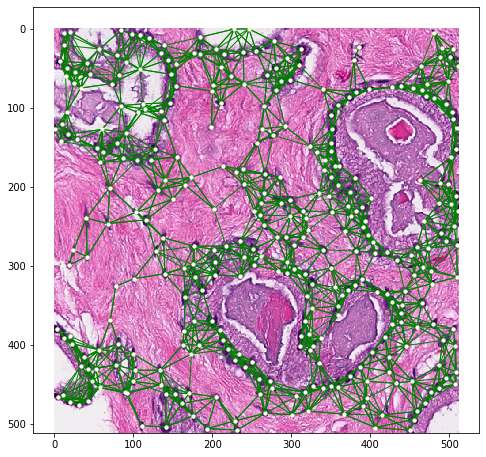

In [134]:
fig, ax = plt.subplots(figsize=(8,8))
data = data_sets[-1]
ax.imshow(tile)
ax.scatter(centroid['x'], centroid['y'], s=10, c='yellow')

for i, j in data.edge_index.T:
    x = [data.pos[i][1], data.pos[j][1]]
    y = [data.pos[i][0], data.pos[j][0]]
    ax.plot(x, y, c='g', lw=1, zorder=100)
ax.scatter(centroid['x'], centroid['y'], s=10, c='white', zorder=1000)

In [142]:
import torch.nn.functional as F
import torch_geometric.nn as nn

from torch_geometric.nn import GCNConv


class Net(torch.nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(Net, self).__init__()
        self.conv1 = GCNConv(in_feats, hidden_size)
        self.conv2 = GCNConv(hidden_size, num_classes)
        self.softmax = torch.nn.Softmax()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = nn.global_mean_pool(F.relu(x), data.batch)

        return F.softmax(x, dim=1)

In [146]:
validation_pct = 0.1
validation_size = int(len(data_sets) * validation_pct)

train_set = data_sets[:-validation_size]
test_set = data_sets[-validation_size:]
print(len(train_set), len(test_set), validation_size)

train_loader = DataLoader(train_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=1)

891 99 99


In [149]:
batch_size = 8
epochs = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_function = torch.nn.MSELoss()
model = Net(len(feature_cols), 50, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()



for epoch in range(epochs):
    for batch in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_function(out, batch.y)
        print(loss)
        loss.backward()
        optimizer.step()
print(loss.item())


3%|▎         | 3/112 [00:00<00:04, 22.02it/s]tensor(2.1562, grad_fn=<MseLossBackward>)
tensor(2.5312, grad_fn=<MseLossBackward>)
tensor(2.4688, grad_fn=<MseLossBackward>)
tensor(1.9688, grad_fn=<MseLossBackward>)
tensor(2.3125, grad_fn=<MseLossBackward>)
  8%|▊         | 9/112 [00:00<00:04, 22.78it/s]tensor(1.8438, grad_fn=<MseLossBackward>)
tensor(nan, grad_fn=<MseLossBackward>)
tensor(nan, grad_fn=<MseLossBackward>)
tensor(nan, grad_fn=<MseLossBackward>)
tensor(nan, grad_fn=<MseLossBackward>)
tensor(nan, grad_fn=<MseLossBackward>)
 14%|█▍        | 16/112 [00:00<00:03, 25.57it/s]tensor(nan, grad_fn=<MseLossBackward>)
tensor(nan, grad_fn=<MseLossBackward>)
tensor(nan, grad_fn=<MseLossBackward>)
tensor(nan, grad_fn=<MseLossBackward>)
tensor(nan, grad_fn=<MseLossBackward>)
tensor(nan, grad_fn=<MseLossBackward>)
 21%|██        | 23/112 [00:00<00:03, 26.81it/s]tensor(nan, grad_fn=<MseLossBackward>)
tensor(nan, grad_fn=<MseLossBackward>)
tensor(nan, grad_fn=<MseLossBackward>)
tensor(nan, gr

In [140]:
loss

tensor(nan, grad_fn=<MseLossBackward>)

In [129]:
model.eval()
x=[]
y=[]
for data in test_loader:
    pred = torch.argmax(model(data))
    
    print(data.y, pred)

tensor([[ 1., -2.],
        [ 1., -2.],
        [ 1., -2.],
        [ 1., -2.],
        [ 0., -1.],
        [ 1., -2.],
        [ 1., -2.],
        [ 0., -1.]]) tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]], grad_fn=<SoftmaxBackward>)
tensor([[ 1., -2.],
        [ 0., -1.],
        [ 1., -2.],
        [ 0., -1.],
        [ 1., -2.],
        [ 1., -2.],
        [ 0., -1.],
        [ 1., -2.]]) tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]], grad_fn=<SoftmaxBackward>)
tensor([[ 0., -1.],
        [ 0., -1.],
        [ 0., -1.],
        [ 1., -2.],
        [ 1., -2.],
        [ 0., -1.],
        [ 0., -1.],
        [ 1., -2.]]) tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]], grad_fn=<SoftmaxBackward>)
t

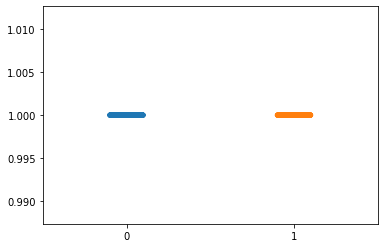

In [77]:
import seaborn as sns
sns.stripplot(x,y)

In [54]:
pred.mean().tolist()

1.0